# Loan Approval Prediction

## 1. Data Loading and Exploration

In [8]:
import pandas as pd
import numpy as np

#Load the dataset
loan_data = pd.read_csv('https://raw.githubusercontent.com/prasertcbs/basic-dataset/refs/heads/master/Loan-Approval-Prediction.csv')
print("Dataset loaded successfully.")
print("Shape of dataset:", loan_data.shape)

# Preview data
print("\nFirst 5 rows:")
print(loan_data.head())

# Dataset structure
print("\nDataset information:")
loan_data.info()

# Missing values
print("\nMissing values per column:")
print(loan_data.isna().sum())

# Statistical summary (numerical features)
print("\nStatistical summary:")
print(loan_data.describe())

# Target distribution
print("\nLoan_Status distribution:")
print(loan_data["Loan_Status"].value_counts())
print("\nLoan_Status distribution (proportion):")
print(loan_data["Loan_Status"].value_counts(normalize=True))

Dataset loaded successfully.
Shape of dataset: (614, 13)

First 5 rows:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban         

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, roc_curve, auc


## 2. Feature Selection and Splitting

In [12]:
# Split features and target
target_col = "Loan_Status"
X = loan_data.drop(columns=[target_col, "Loan_ID"])
y = loan_data[target_col].map({"Y": 1, "N": 0})

## 3. Building the Pre-Processing Pipeline

In [22]:
# Numeric vs categorical columns (based on the dataset)
numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
categorical_features = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]
# 1. Define pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fill missing values with median
    ('scaler', StandardScaler())                   # Standardize features (mean=0, variance=1)
])
# 2. Define pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # Convert categories to binary vectors
])
# 3. Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply numerical pipeline to specific numeric columns
        ('num', numerical_transformer, numerical_features),
        # Apply categorical pipeline to specific categorical columns
        ('cat', categorical_transformer, categorical_features)
    ])
# 4. Create the full end-to-end pipeline including the model
# This ensures raw data flows through preprocessing directly into the model
# 4a. Logistic Regression pipeline
lr_model = LogisticRegression()
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', lr_model)
                          ])
# 4b. KNN pipeline
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
    ("model", knn_model)])

## 4. Training and Evaluation

In [25]:
# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Logistic Regression
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)[:, 1]

# KNN
knn_pipeline.fit(X_train, y_train)
knn_preds = knn_pipeline.predict(X_test)
knn_proba = knn_pipeline.predict_proba(X_test)[:, 1]

In [28]:

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n{model_name} Performance")
    print("-" * 30)
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))

    # AUC score
    auc_score = roc_auc_score(y_true, y_proba)
    print("AUC  :", auc_score)

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc_from_curve = auc(fpr, tpr)  # should match auc_score
    return fpr, tpr, thresholds, auc_from_curve

# Evaluate Logistic Regression
fpr_lr, tpr_lr, thr_lr, auc_lr = evaluate_model(y_test, lr_preds, lr_proba, "Logistic Regression")

# Evaluate KNN
fpr_knn, tpr_knn, thr_knn, auc_knn = evaluate_model(y_test, knn_preds, knn_proba, "KNN")



Logistic Regression Performance
------------------------------
Accuracy : 0.8211382113821138
Precision: 0.8
Recall   : 0.9882352941176471
F1-score : 0.8842105263157894
AUC  : 0.8191950464396285

KNN Performance
------------------------------
Accuracy : 0.8292682926829268
Precision: 0.8076923076923077
Recall   : 0.9882352941176471
F1-score : 0.888888888888889
AUC  : 0.781733746130031


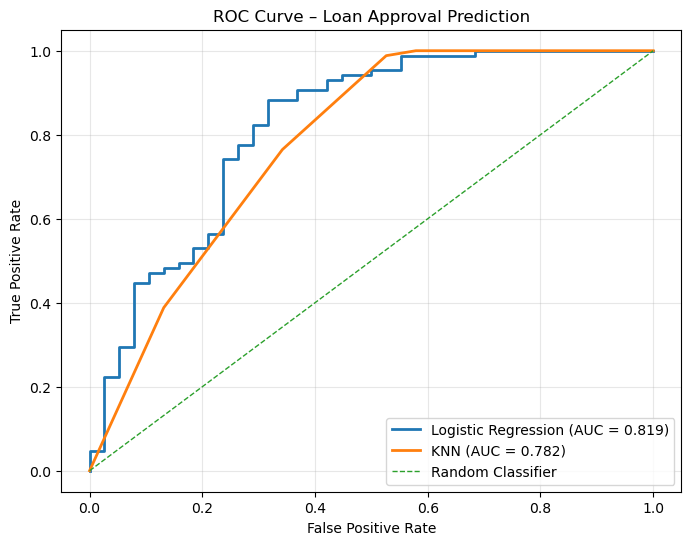

In [29]:
# ROC Curve Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Logistic Regression ROC
plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"Logistic Regression (AUC = {auc_lr:.3f})",
    linewidth=2
)

# KNN ROC
plt.plot(
    fpr_knn,
    tpr_knn,
    label=f"KNN (AUC = {auc_knn:.3f})",
    linewidth=2
)

# Random classifier baseline
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random Classifier")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Loan Approval Prediction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()


The ROC curves show that both Logistic Regression and KNN perform substantially better than random guessing. 
Logistic Regression achieves a higher ROC AUC (0.819) compared to KNN (0.782), indicating higher ability to differentiate between approved and non-approved loans across different thresholds. The Logistic Regression curve consistently lies above the KNN curve, particularly at lower false positive rates, making it a more reliable model for loan approval prediction.